## DRACH Motifs

The middle 5-mers of the sequence will always be one of the 18 DRACH motifs.

In [1]:
# Define the possible nucleotides for each position
D = ['A', 'G', 'T']
R = ['A', 'G']
A = ['A']
C = ['C']
H = ['A', 'C', 'T']

# Initialize an empty list to store the DRACH motifs
drach_motifs = []

# Generate all combinations using nested loops
for d in D:
    for r in R: 
        for a in A:
            for c in C:
                for h in H:
                    motif = d + r + a + c + h
                    drach_motifs.append(motif)

# Print the list of DRACH motifs
print(drach_motifs)

['AAACA', 'AAACC', 'AAACT', 'AGACA', 'AGACC', 'AGACT', 'GAACA', 'GAACC', 'GAACT', 'GGACA', 'GGACC', 'GGACT', 'TAACA', 'TAACC', 'TAACT', 'TGACA', 'TGACC', 'TGACT']


## Loading The Data

In [2]:
import gzip
import json
import pandas as pd

### `dataset0.json.gz`

In [3]:
# Function to load data.json.gz file as dataframe
def load_json_gz_to_dataframe(file_path):
    data = []
    with gzip.open(file_path) as f:
        for line in f.readlines():
            json_data = json.loads(line)
            for transcript, positions in json_data.items():
                for position, sequences in positions.items():
                    position = int(position)
                    for sequence, reads in sequences.items():
                        data.append({
                            'transcript_id': transcript,
                            'position': position,
                            'sequence': sequence,
                            "data": reads
                            })
    return pd.DataFrame(data)

In [4]:
# Change the file path to the location of your dataset
file_path = 'dataset0.json.gz'
dataset = load_json_gz_to_dataframe(file_path)
dataset.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[[0.00299, 2.06, 125.0, 0.0177, 10.4, 122.0, 0..."
1,ENST00000000233,261,CAAACTG,"[[0.0126, 1.95, 111.0, 0.0125, 1.27, 108.0, 0...."
2,ENST00000000233,316,GAAACAG,"[[0.00432, 2.02, 104.0, 0.00299, 3.56, 99.3, 0..."


### `data.info.labelled`

In [5]:
# Change the file path to the location of your labels
file_path = 'data.info.labelled'
labels = pd.read_csv(file_path)
labels.head(3)

,gene_id,transcript_id,transcript_position,label
0,ENSG00000004059,ENST00000000233,244,0
1,ENSG00000004059,ENST00000000233,261,0
2,ENSG00000004059,ENST00000000233,316,0


## Exploratory Data Analysis, Feature Engineering & Data Preprocessing

In [6]:
import numpy as np
from matplotlib import pyplot as plt

1. Take the mean of the reads for each row

In [7]:
# Create a copy of the dataset
df = dataset.copy()

# Take the mean of the reads
df['data'] = df['data'].apply(lambda x: np.mean(x, axis=0))
df.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AAGACCA,"[0.008264378378378385, 4.223783783783786, 123...."
1,ENST00000000233,261,CAAACTG,"[0.006609244186046515, 3.2164244186046504, 109..."
2,ENST00000000233,316,GAAACAG,"[0.0075699999999999995, 2.94054054054054, 105...."


2. Scale the data

In [8]:
from sklearn.preprocessing import StandardScaler
import joblib

In [9]:
# Extract the lists from the 'data' column
data_lists = np.vstack(df['data'].values)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
data_scaled = scaler.fit_transform(data_lists)

# Replace the original 'data' column with the scaled data
df['data'] = list(data_scaled)

# Save the scaler to a file
# joblib.dump(scaler, 'scaler.pkl')

3. Extract the middle 5-mers sequence

In [10]:
# Extract the middle 5-mers sequence
df['sequence'] = df['sequence'].apply(lambda x: x[1:-1])
df.head(3)

,transcript_id,position,sequence,data
0,ENST00000000233,244,AGACC,"[0.08776110205467978, -0.06111956233627649, 1...."
1,ENST00000000233,261,AAACT,"[-0.8386145009573266, -0.5813801345374859, -0...."
2,ENST00000000233,316,AAACA,"[-0.30088121587273425, -0.7238630549570515, -0..."


<Axes: xlabel='sequence'>

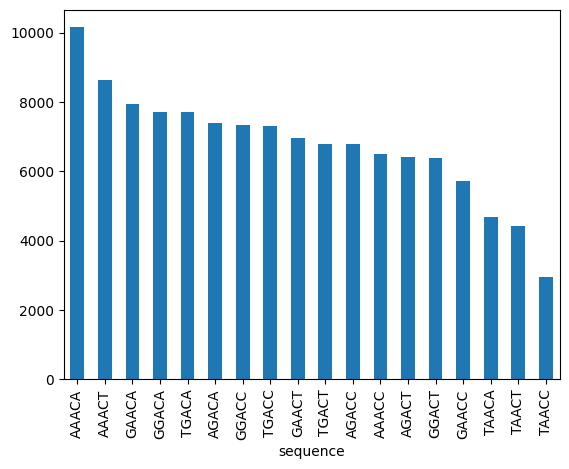

In [10]:
# Plot the distribution of sequence
df['sequence'].value_counts().plot(kind='bar')

4. Perform one-hot encoding on extracted 5-mers sequence

In [11]:
from sklearn.preprocessing import OneHotEncoder

In [12]:
# Initialize the OneHotEncoder with DRACH motifs
encoder = OneHotEncoder(categories=[drach_motifs])

# Fit the encoder to 'sequence' and transform it into a one-hot encoded matrix
one_hot_matrix = encoder.fit_transform(df[['sequence']])

# Convert the one-hot encoded matrix into a column
one_hot_column = pd.Series([list(row) for row in one_hot_matrix.toarray()])

# Concatenate the one-hot encoded column to df
df_encoded = pd.concat([df, one_hot_column.rename('one_hot_encoded')], axis=1)

# Combine 'data' and 'one_hot_encoded' into a single list for each row
df_encoded['combined'] = df_encoded.apply(lambda x: x['data'].tolist() + x['one_hot_encoded'], axis=1)

df_encoded.head(3)

,transcript_id,position,sequence,data,one_hot_encoded,combined
0,ENST00000000233,244,AGACC,"[0.08776110205467978, -0.06111956233627649, 1....","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08776110205467978, -0.06111956233627649, 1...."
1,ENST00000000233,261,AAACT,"[-0.8386145009573266, -0.5813801345374859, -0....","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.8386145009573266, -0.5813801345374859, -0...."
2,ENST00000000233,316,AAACA,"[-0.30088121587273425, -0.7238630549570515, -0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.30088121587273425, -0.7238630549570515, -0..."


5. Inner join the dataset and labels on the transcript id and position

In [13]:
# Inner join df on labels
merged_df = pd.merge(df_encoded, labels,
                     left_on  = ['transcript_id', 'position'],
                     right_on = ['transcript_id', 'transcript_position'],
                     how = 'left')

# Drop the duplicate column and reorder the columns
gene_id = merged_df['gene_id']
merged_df = merged_df.drop(columns=['transcript_position', 'gene_id'])
merged_df.insert(0, 'gene_id', gene_id)

merged_df.head(3)

,gene_id,transcript_id,position,sequence,data,one_hot_encoded,combined,label
0,ENSG00000004059,ENST00000000233,244,AGACC,"[0.08776110205467978, -0.06111956233627649, 1....","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08776110205467978, -0.06111956233627649, 1....",0
1,ENSG00000004059,ENST00000000233,261,AAACT,"[-0.8386145009573266, -0.5813801345374859, -0....","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.8386145009573266, -0.5813801345374859, -0....",0
2,ENSG00000004059,ENST00000000233,316,AAACA,"[-0.30088121587273425, -0.7238630549570515, -0...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.30088121587273425, -0.7238630549570515, -0...",0


6. Split the dataset into train and test sets by gene_id

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# Train-test split by gene_id
train_genes, test_genes = train_test_split(labels['gene_id'].unique(), test_size=0.3, random_state=42)

train_df = merged_df[merged_df['gene_id'].isin(train_genes)]
test_df  = merged_df[merged_df['gene_id'].isin(test_genes)]

X_train = np.vstack(train_df['combined'].values)
y_train = train_df['label'].values

X_test = np.vstack(test_df['combined'].values)
y_test = test_df['label'].values

7. Apply Synthetic Minority Over-sampling Technique (SMOTE)

In [16]:
from imblearn.over_sampling import SMOTE

In [17]:
# Proportion of positive labels before SMOTE
print(f'Proportion of positive labels before SMOTE: {np.mean(y_train):.4f}')

Proportion of positive labels before SMOTE: 0.0465


In [18]:
# Simulate data with label 1 using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [19]:
# Proportion of positive labels after SMOTE
print(f'Proportion of positive labels after SMOTE: {np.mean(y_resampled):.4f}')

Proportion of positive labels after SMOTE: 0.5000


## Baseline Model: Logistic Regression

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

Model Training

In [86]:
# Initialize the logistic regression model
log_reg_model = LogisticRegression()

# Define the hyperparameters and their values for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],  # C is the inverse of regularization strength
    'penalty': ['l1', 'l2'], # l1 is Lasso, l2 is Ridge
    'solver': ['liblinear']  # 'liblinear' supports both 'l1' and 'l2' penalties
}

# Use GridSearchCV for hyperparameter tuning
# Use average precision as the scoring metric to handle imbalanced data
grid_search = GridSearchCV(log_reg_model, param_grid, cv=5, scoring='average_precision')
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_log_reg_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Save the best logistic regression model to a file
# joblib.dump(best_log_reg_model, 'best_log_reg_model.pkl')

Best Parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}


Model Evaluation

In [87]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

In [88]:
# Create the best logistic regression model if not loaded
# From file
# best_log_reg_model = joblib.load('best_log_reg_model.pkl')

# Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
best_log_reg_model = LogisticRegression(C=10, penalty='l1', solver='liblinear')

# Fit the model
best_log_reg_model.fit(X_resampled, y_resampled)

LogisticRegression(C=10, penalty='l1', solver='liblinear')

Average Precision Score (Logistic Regression): 0.12567503367438


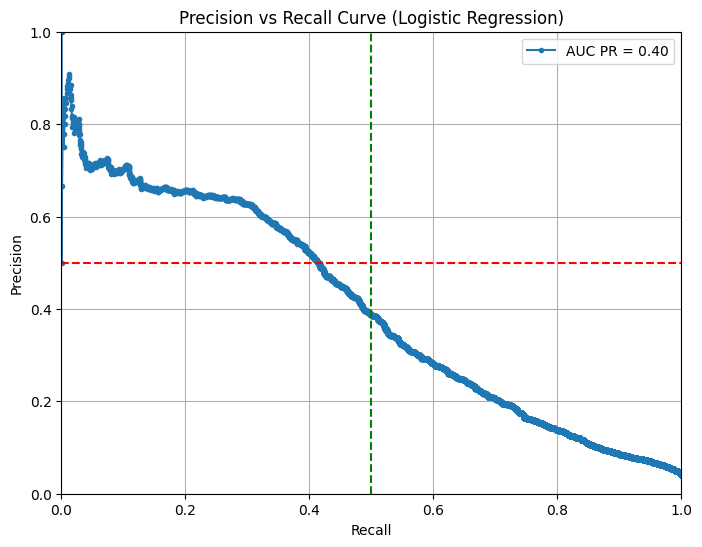

AUC-PR Score (Logistic Regression): 0.40014513763338466


In [89]:
# Get the class prediction
y_pred_lr = best_log_reg_model.predict(X_test)

# Calculate the average precision score
average_precision_lr = average_precision_score(y_test, y_pred_lr)
print("Average Precision Score (Logistic Regression):", average_precision_lr)

# Get the probabilities for the positive class
y_scores_lr = best_log_reg_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_scores_lr)

# Calculate the AUC for the Precision-Recall curve
auc_pr_lr = auc(recall_lr, precision_lr)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, marker='.', label=f'AUC PR = {auc_pr_lr:.2f}')
plt.title('Precision vs Recall Curve (Logistic Regression)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR score
print("AUC-PR Score (Logistic Regression):", auc_pr_lr)

## Advanced Model: Some neural network

In [20]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC

c:\Users\okk15\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model Creation

In [66]:
def objective(trial):
    model = Sequential()

    # choose number of layers
    num_layers = trial.suggest_int('num_layers', 2, 3)
    for i in range(num_layers):

        # choose number of features
        features = trial.suggest_int(f'units_{i}', 32, 256, step=32)

        # choose activation function
        activation_function = trial.suggest_categorical(f'activation_{i}',['relu', 'tanh', 'sigmoid'])

        # choose dropout rate
        dropout_rate = trial.suggest_float(f'dropout_{i}', 0.0, 0.5)

        model.add(Dense(features, activation = activation_function))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-2, log = True)),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

    history = model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    y_pred = model.predict(X_resampled)
    auc_score = roc_auc_score(y_resampled, y_pred)

    return auc_score

# Create and run the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get best hyperparameters
print(study.best_params)

[I 2024-10-12 17:30:53,355] A new study created in memory with name: no-name-d6764b25-528a-45c9-97b0-f43e80afa6a3


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 525us/step


[I 2024-10-12 17:31:37,949] Trial 0 finished with value: 0.9239562815339873 and parameters: {'num_layers': 3, 'units_0': 160, 'activation_0': 'tanh', 'dropout_0': 0.25841667078055486, 'units_1': 224, 'activation_1': 'sigmoid', 'dropout_1': 0.14772994166293868, 'units_2': 64, 'activation_2': 'tanh', 'dropout_2': 0.09799975357600182, 'learning_rate': 0.008840653023000708}. Best is trial 0 with value: 0.9239562815339873.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 550us/step


[I 2024-10-12 17:32:20,288] Trial 1 finished with value: 0.932811114968377 and parameters: {'num_layers': 2, 'units_0': 224, 'activation_0': 'tanh', 'dropout_0': 0.4465885155829479, 'units_1': 224, 'activation_1': 'sigmoid', 'dropout_1': 0.08763971777269663, 'learning_rate': 0.00397761144500326}. Best is trial 1 with value: 0.932811114968377.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 495us/step


[I 2024-10-12 17:33:01,514] Trial 2 finished with value: 0.8910717235441439 and parameters: {'num_layers': 3, 'units_0': 256, 'activation_0': 'relu', 'dropout_0': 0.11321063137321291, 'units_1': 32, 'activation_1': 'relu', 'dropout_1': 0.2741512712398973, 'units_2': 128, 'activation_2': 'tanh', 'dropout_2': 0.29951397221289205, 'learning_rate': 0.008107590064269754}. Best is trial 1 with value: 0.932811114968377.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 516us/step


[I 2024-10-12 17:33:38,021] Trial 3 finished with value: 0.8918905283371481 and parameters: {'num_layers': 2, 'units_0': 32, 'activation_0': 'tanh', 'dropout_0': 0.22761968309547248, 'units_1': 160, 'activation_1': 'tanh', 'dropout_1': 0.03710957685569516, 'learning_rate': 0.00019129428172166705}. Best is trial 1 with value: 0.932811114968377.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 502us/step


[I 2024-10-12 17:34:16,147] Trial 4 finished with value: 0.878675996018821 and parameters: {'num_layers': 2, 'units_0': 224, 'activation_0': 'sigmoid', 'dropout_0': 0.43115201907208034, 'units_1': 64, 'activation_1': 'tanh', 'dropout_1': 0.46258418608596474, 'learning_rate': 0.00041241608926509074}. Best is trial 1 with value: 0.932811114968377.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 518us/step


[I 2024-10-12 17:34:56,943] Trial 5 finished with value: 0.9454326276969045 and parameters: {'num_layers': 2, 'units_0': 160, 'activation_0': 'relu', 'dropout_0': 0.3530259658761528, 'units_1': 224, 'activation_1': 'relu', 'dropout_1': 0.46646509988895984, 'learning_rate': 0.0013802351294901387}. Best is trial 5 with value: 0.9454326276969045.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 515us/step


[I 2024-10-12 17:35:37,352] Trial 6 finished with value: 0.8708059586010568 and parameters: {'num_layers': 3, 'units_0': 64, 'activation_0': 'sigmoid', 'dropout_0': 0.028240334347406693, 'units_1': 96, 'activation_1': 'sigmoid', 'dropout_1': 0.08245640795482712, 'units_2': 64, 'activation_2': 'tanh', 'dropout_2': 0.45204954917930495, 'learning_rate': 0.00012975745569493414}. Best is trial 5 with value: 0.9454326276969045.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step


[I 2024-10-12 17:36:13,901] Trial 7 finished with value: 0.9561242574512189 and parameters: {'num_layers': 2, 'units_0': 128, 'activation_0': 'relu', 'dropout_0': 0.1880448819631122, 'units_1': 96, 'activation_1': 'relu', 'dropout_1': 0.010390332231766886, 'learning_rate': 0.004748298653894996}. Best is trial 7 with value: 0.9561242574512189.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 3s 512us/step


[I 2024-10-12 17:36:52,280] Trial 8 finished with value: 0.8924538466485533 and parameters: {'num_layers': 2, 'units_0': 192, 'activation_0': 'tanh', 'dropout_0': 0.07669173037756544, 'units_1': 96, 'activation_1': 'tanh', 'dropout_1': 0.40325437969978273, 'learning_rate': 0.00019053342408986416}. Best is trial 7 with value: 0.9561242574512189.


5043/5043 ━━━━━━━━━━━━━━━━━━━━ 2s 470us/step


[I 2024-10-12 17:37:28,959] Trial 9 finished with value: 0.8986810305977342 and parameters: {'num_layers': 2, 'units_0': 96, 'activation_0': 'sigmoid', 'dropout_0': 0.44817236573473473, 'units_1': 128, 'activation_1': 'sigmoid', 'dropout_1': 0.32918095748541654, 'learning_rate': 0.0015915042994755649}. Best is trial 7 with value: 0.9561242574512189.


{'num_layers': 2, 'units_0': 128, 'activation_0': 'relu', 'dropout_0': 0.1880448819631122, 'units_1': 96, 'activation_1': 'relu', 'dropout_1': 0.010390332231766886, 'learning_rate': 0.004748298653894996}


In [67]:
def build_model(best_hps):
    model = Sequential()

    # pick optimum layers
    for i in range(best_hps['num_layers']):

        # pick optimum features
        features = best_hps[f'units_{i}']

        # pick optimum activation function
        activation_function = best_hps[f'activation_{i}']

        # pick optimum dropout rate
        dropout_rate = best_hps[f'dropout_{i}']

        model.add(Dense(features, activation = activation_function))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=best_hps['learning_rate']),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint('best_model_hp.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    
    model.fit(X_resampled, y_resampled, epochs=10, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

    return model

best_hps = study.best_params
# cur_best = {'num_layers': 2, 'units_0': 128, 'activation_0': 'relu', 'dropout_0': 0.1880448819631122, 'units_1': 96, 'activation_1': 'relu', 'dropout_1': 0.010390332231766886, 'learning_rate': 0.004748298653894996}
best_model = build_model(best_hps)

Epoch 1/10
4021/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - accuracy: 0.8046 - loss: 0.4277
Epoch 1: val_accuracy improved from -inf to 0.76662, saving model to best_model_hp.keras
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 4s 821us/step - accuracy: 0.8047 - loss: 0.4276 - val_accuracy: 0.7666 - val_loss: 0.4701
Epoch 2/10
4030/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.8390 - loss: 0.3645
Epoch 2: val_accuracy improved from 0.76662 to 0.78936, saving model to best_model_hp.keras
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 798us/step - accuracy: 0.8390 - loss: 0.3645 - val_accuracy: 0.7894 - val_loss: 0.4050
Epoch 3/10
3997/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.8473 - loss: 0.3485
Epoch 3: val_accuracy did not improve from 0.78936
4035/4035 ━━━━━━━━━━━━━━━━━━━━ 3s 801us/step - accuracy: 0.8473 - loss: 0.3485 - val_accuracy: 0.7712 - val_loss: 0.4533
Epoch 4/10
4013/4035 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.8523 - loss: 0.3361
Epoch 4: val_accuracy did not improve from 0.

Model Evaluation

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step


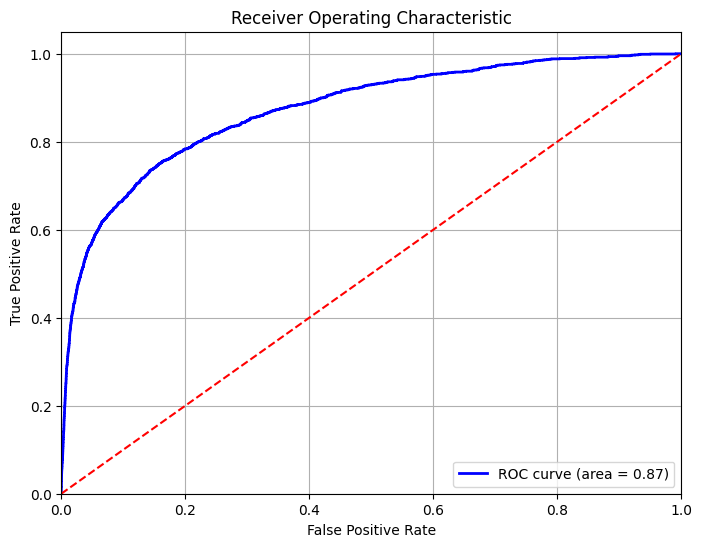

AUC-ROC Score: 0.8729909869748605


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

# Assuming you have a test set
# X_test: shape (num_samples, 9)
# y_test: shape (num_samples,) with binary labels (0 or 1)
# Make predictions
predictions = best_model.predict(X_test)

# Get the predicted probabilities for the positive class
predicted_probabilities = predictions

# Calculate the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, predicted_probabilities)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print AUC score
print("AUC-ROC Score:", roc_auc)

In [55]:
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

1164/1164 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step
Average Precision Score (Neural Network): 0.4288193736544244


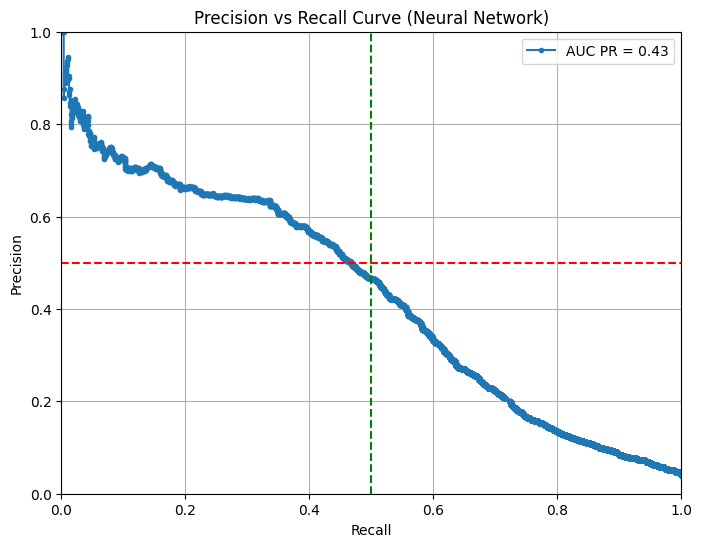

AUC-PR Score (Neural Network): 0.4285552205937868


In [56]:
# Make predictions on the test set using the neural network model
nn_predicted_probabilities = best_model.predict(X_test).flatten()  # Flatten to 1D array

# Calculate precision, recall, and thresholds for the neural network model
precision_nn, recall_nn, thresholds_nn = precision_recall_curve(y_test, nn_predicted_probabilities)

# Calculate average precision score for the neural network model
average_precision_nn = average_precision_score(y_test, nn_predicted_probabilities)
print("Average Precision Score (Neural Network):", average_precision_nn)

# Calculate the AUC for the Precision-Recall curve for the neural network model
auc_pr_nn = auc(recall_nn, precision_nn)

# Plot Precision-Recall curve for the neural network model
plt.figure(figsize=(8, 6))
plt.plot(recall_nn, precision_nn, marker='.', label=f'AUC PR = {auc_pr_nn:.2f}')
plt.title('Precision vs Recall Curve (Neural Network)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR score for the neural network model
print("AUC-PR Score (Neural Network):", auc_pr_nn)


## Comparing the two models

Average Precision Score for Logistic Regression: 0.126
Average Precision Score for Neural Network: 0.426


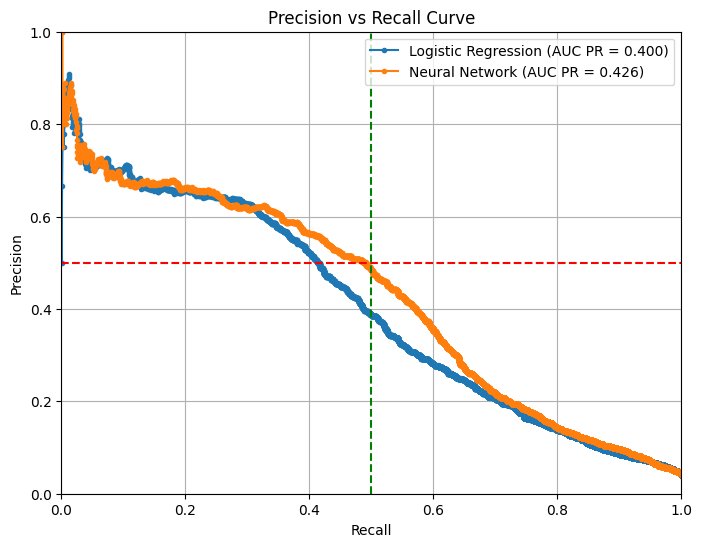

AUC-PR Score for Logistic Regression: 0.40014513763338466
AUC-PR Score for Neural Network: 0.4257768679015994


In [90]:
# Average Precision Scores
print(f"Average Precision Score for Logistic Regression: {average_precision_lr:.3f}")
print(f"Average Precision Score for Neural Network: {average_precision_nn:.3f}")

# Plot both curves
plt.figure(figsize=(8, 6))
plt.plot(recall_lr, precision_lr, marker='.', label=f'Logistic Regression (AUC PR = {auc_pr_lr:.3f})')
plt.plot(recall_nn, precision_nn, marker='.', label=f'Neural Network (AUC PR = {auc_pr_nn:.3f})')
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.axhline(y=0.5, color='r', linestyle='--')  # Reference line for 0.5 precision
plt.axvline(x=0.5, color='g', linestyle='--')  # Reference line for 0.5 recall
plt.legend()
plt.show()

# Print AUC PR scores
print("AUC-PR Score for Logistic Regression:", auc_pr_lr)
print("AUC-PR Score for Neural Network:", auc_pr_nn)